# Predicting Crowdfunding Success
Using kNN, logistic regression model, support vector machine, naive bayes to predict success rate of crowdfunding.

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix 

from sklearn.naive_bayes import GaussianNB

%matplotlib inline

# Data Cleaning & Processing

In [2]:
df = pd.read_csv('./data/data.csv')
df.head(1)

,Unnamed: 0,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,currency_symbol,currency_trailing_code,...,static_usd_rate,usd_pledged,usd_type,preparation_duration,preparation_duration_r,launch_duration,launch_duration_r,created_at_readable,deadline_readable,launched_at_readable
0,1,21,2006 was almost 7 years ago.... Can you believ...,Rock,802,US,1387659690,USD,$,True,...,1.0,802.0,international,351356,4d 1H 35M 56S,3888000,45d 0H 0M 0S,2013-12-21 16:01:30,2014-02-08 17:37:26,2013-12-25 17:37:26


In [3]:
df.shape

(3779, 41)

In [4]:
df.state.value_counts()

successful    2224
failed        1276
canceled       149
live           120
suspended       10
Name: state, dtype: int64

In [5]:
# drop status rows labeled as live, canceled, suspended.
df = df[~df['state'].isin(['live', 'canceled', 'suspended'])]
df.shape

(3500, 41)

In [6]:
# drop irrelevant or independent variables
df.drop(['Unnamed: 0', 'blurb', 'created_at', 'currency_symbol', 'currency_trailing_code', 'current_currency',
         'deadline', 'disable_communication', 'friends', 'id',
         'is_backing', 'is_starred', 'launched_at', 'state_changed_at',
         'name', 'permissions', 'profile', 'source_url', 'staff_pick', 
         'preparation_duration_r', 'launch_duration_r',
         'created_at_readable', 'deadline_readable', 'launched_at_readable', 
         'location', 'usd_type'], axis = 1, inplace = True)
df.head()

,backers_count,category,converted_pledged_amount,country,currency,fx_rate,goal,is_starrable,pledged,spotlight,state,static_usd_rate,usd_pledged,preparation_duration,launch_duration
0,21,Rock,802,US,USD,1.000000,200.0,False,802.0,True,successful,1.000000,802.000000,351356,3888000
1,97,Mixed Media,2259,US,USD,1.000000,400.0,False,2259.0,True,successful,1.000000,2259.000000,413843,1728000
2,88,Photobooks,29638,US,USD,1.000000,27224.0,False,29638.0,True,successful,1.000000,29638.000000,769946,2595600
3,193,Footwear,49158,IT,EUR,1.128433,40000.0,False,43180.0,True,successful,1.136525,49075.152523,314662,3625358
4,20,Software,549,US,USD,1.000000,1000.0,False,549.0,False,failed,1.000000,549.000000,212500,2592000


In [7]:
df['state'] = df.state.str.contains('successful').astype(int)

In [8]:
# add column representing continent
def classifier(row):
    if row.country in ['US', 'CA', 'GT', 'MX', 'PR', 'NI', 'SV', 'PA', 'BO', 'GU']:
        return 'America'
    elif row.country in ['NG', 'GH', 'ZA', 'KE', 'ET', 'CD', 'MA', 'TZ', 'ZM', 'LR', 'RW', 'ML', 'CM', 'NA', 'ZW', 'TN', 'SL', 'CF', 'UG', 'SD', 'SN', 'MW', 'MZ', 'LY', 'GN', 'SZ']:
        return 'Africa'
    elif row.country in ['GB', 'NO', 'DE', 'SE', 'BA', 'IS', 'HU', 'IT', 'NL','FR', 'UK', 'AT',
       'TR','FI', 'CZ','AM', 'PT','DK','CH', 'SJ', 'RU', 'UA', 'BG','ES','PL', 'GE','IE','GR','RS','SI','BE','GL','RO','LT', 'FM','EE','CY', 'MK','KG',]:
        return 'Europe'
    elif row.country in ['JM', 'HT','BS','DO','LC', 'DO', 'TT']:
        return 'Carribean'
    elif row.country in ['CN', 'TW', 'HK', 'NP', 'ID', 'SG', 'IN', 'JP', 'LB', 'KZ', 'KR', 'PH', 'KH', 'TH','MY','BT','LK','BM','VN','BD', 'LA','GU']:
        return 'Asia'
    elif row.country in ['IL','QA', 'AF','KZ','AE','PS','SY','SA', 'IQ','IR','TJ',]:
        return 'Arab'
    else:
        return "Oceania"   
df["continent"] = df.apply(classifier, axis=1)

In [9]:
df.head()

,backers_count,category,converted_pledged_amount,country,currency,fx_rate,goal,is_starrable,pledged,spotlight,state,static_usd_rate,usd_pledged,preparation_duration,launch_duration,continent
0,21,Rock,802,US,USD,1.000000,200.0,False,802.0,True,1,1.000000,802.000000,351356,3888000,America
1,97,Mixed Media,2259,US,USD,1.000000,400.0,False,2259.0,True,1,1.000000,2259.000000,413843,1728000,America
2,88,Photobooks,29638,US,USD,1.000000,27224.0,False,29638.0,True,1,1.000000,29638.000000,769946,2595600,America
3,193,Footwear,49158,IT,EUR,1.128433,40000.0,False,43180.0,True,1,1.136525,49075.152523,314662,3625358,Europe
4,20,Software,549,US,USD,1.000000,1000.0,False,549.0,False,0,1.000000,549.000000,212500,2592000,America


In [10]:
from sklearn import preprocessing
def encode_features(df):
    features = ['category', 'country', 'currency', 'is_starrable', 'continent', 'spotlight']
    df_combined = pd.concat([df])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df[feature] = le.transform(df[feature])
    return df
    
data = encode_features(df)
data.head()

,backers_count,category,converted_pledged_amount,country,currency,fx_rate,goal,is_starrable,pledged,spotlight,state,static_usd_rate,usd_pledged,preparation_duration,launch_duration,continent
0,21,120,802,20,13,1.000000,200.0,0,802.0,1,1,1.000000,802.000000,351356,3888000,0
1,97,83,2259,20,13,1.000000,400.0,0,2259.0,1,1,1.000000,2259.000000,413843,1728000,0
2,88,99,29638,20,13,1.000000,27224.0,0,29638.0,1,1,1.000000,29638.000000,769946,2595600,0
3,193,59,49158,12,4,1.128433,40000.0,0,43180.0,1,1,1.136525,49075.152523,314662,3625358,2
4,20,126,549,20,13,1.000000,1000.0,0,549.0,0,0,1.000000,549.000000,212500,2592000,0


In [11]:
df.continent.value_counts()

0    2677
2     689
3      98
1      36
Name: continent, dtype: int64

In [12]:
X = df.drop(['preparation_duration', 'launch_duration', 'state', 'backers_count', 'spotlight', 'pledged'], axis=1)
y = df['state']

In [13]:
from sklearn.preprocessing import Imputer
X = Imputer().fit_transform(X)

# kNN Model

In [14]:
k_range = range(1,200)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring = 'accuracy')
    k_scores.append(scores.mean())
print('Computed k_scores for k value in range 1 to 200.')

Computed k_scores for k value in range 1 to 200.


In [15]:
scores.mean()

0.9605670786816919

In [16]:
scores.max()

0.9885386819484241

Text(0,0.5,'cross-validated accuracy')

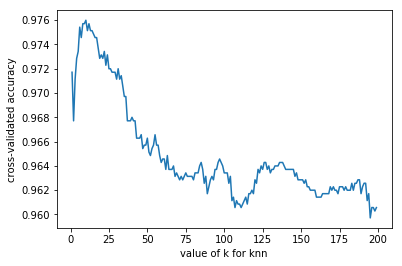

In [16]:
plt.plot(k_range, k_scores)
plt.xlabel('value of k for knn')
plt.ylabel('cross-validated accuracy')

In [17]:
MSE = [1 - x for x in k_scores]
optimal_k = k_range[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 10


# Logistic Regression Model

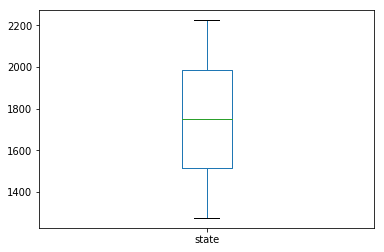

In [18]:
df.state.value_counts().plot(kind = 'box')

In [19]:
ss = StandardScaler()
lr = LogisticRegression()
lr_pipe = Pipeline([('sscale', ss), ('logreg', lr)])

In [20]:
lr_pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('sscale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [21]:
lr_pipe.score(X,y)

0.838

In [22]:
# divide the dataset into 
#  - 70% training data
#  - 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [23]:
lr_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('sscale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [24]:
lr_pipe.score(X_test, y_test) 

0.8133333333333334

In [25]:
y_pred = lr_pipe.predict(X_test)

In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [27]:
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))
print(confusion_matrix(y_test,y_pred)) 
print(classification_report(y_test,y_pred))

0.7979183032207384
0.802507012622721
0.794344333478072
[[282 110]
 [ 86 572]]
             precision    recall  f1-score   support

          0       0.77      0.72      0.74       392
          1       0.84      0.87      0.85       658

avg / total       0.81      0.81      0.81      1050



# Support Vector Machine

In [ ]:
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train) 

In [31]:
y_pred = svclassifier.predict(X_test) 

In [32]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[386   0]
 [  0 664]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       386
          1       1.00      1.00      1.00       664

avg / total       1.00      1.00      1.00      1050



# Naive Bayes

In [28]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [29]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[383   9]
 [479 179]]
             precision    recall  f1-score   support

          0       0.44      0.98      0.61       392
          1       0.95      0.27      0.42       658

avg / total       0.76      0.54      0.49      1050



# Data Visualization

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


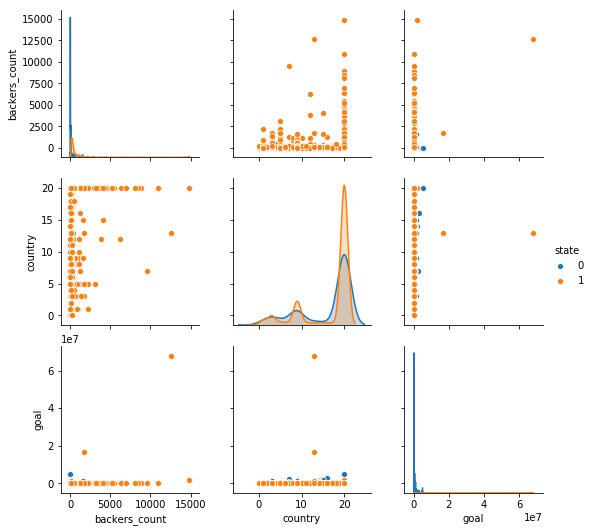

In [33]:
plots = sns.pairplot(df, vars = ['backers_count', 'country', 'goal'], 
                     hue="state")

In [34]:
df = df.drop(['is_starrable'], axis=1)
corr = df.corr()
corr

,backers_count,category,converted_pledged_amount,country,currency,fx_rate,goal,pledged,spotlight,state,static_usd_rate,usd_pledged,preparation_duration,launch_duration,continent
backers_count,1.000000,0.074279,0.855609,0.031723,0.027896,-0.023226,0.330618,0.357206,0.174372,0.174372,-0.031860,0.855154,0.051476,0.043758,-0.023403
category,0.074279,1.000000,0.056564,-0.007631,-0.011621,-0.007235,0.039287,0.034792,-0.062161,-0.062161,-0.006960,0.056879,-0.007718,0.028363,0.023315
converted_pledged_amount,0.855609,0.056564,1.000000,0.031882,0.027261,-0.008231,0.198685,0.229725,0.140590,0.140590,-0.015069,0.999866,0.061744,0.051582,-0.015755
country,0.031723,-0.007631,0.031882,1.000000,0.984185,0.005072,-0.015072,-0.011316,0.047634,0.047634,-0.102557,0.031217,0.026465,-0.016174,-0.746953
currency,0.027896,-0.011621,0.027261,0.984185,1.000000,0.001718,-0.020479,-0.016289,0.048726,0.048726,-0.106477,0.026642,0.028097,-0.018033,-0.773095
fx_rate,-0.023226,-0.007235,-0.008231,0.005072,0.001718,1.000000,-0.111385,-0.107551,0.002059,0.002059,0.963558,-0.008874,-0.002326,-0.025344,0.195684
goal,0.330618,0.039287,0.198685,-0.015072,-0.020479,-0.111385,1.000000,0.991735,-0.000156,-0.000156,-0.102855,0.204915,0.009646,0.020797,0.015929
pledged,0.357206,0.034792,0.229725,-0.011316,-0.016289,-0.107551,0.991735,1.000000,0.023665,0.023665,-0.099714,0.235897,0.010948,0.011791,0.012159
spotlight,0.174372,-0.062161,0.140590,0.047634,0.048726,0.002059,-0.000156,0.023665,1.000000,1.000000,-0.004343,0.140219,0.012206,-0.144859,-0.043037
state,0.174372,-0.062161,0.140590,0.047634,0.048726,0.002059,-0.000156,0.023665,1.000000,1.000000,-0.004343,0.140219,0.012206,-0.144859,-0.043037


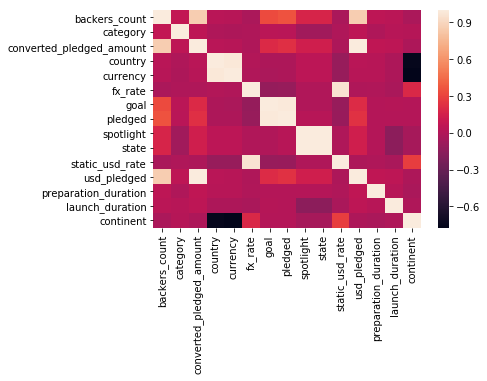

In [35]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

# Citation
Lamidi, Adebola, and Adebola Lamidi. “Predicting the Success of Kickstarter Campaigns.” Towards Data Science, Towards Data Science, 20 Sept. 2017, towardsdatascience.com/predicting-the-success-of-kickstarter-campaigns-3f4a976419b9.

“Kickstarter: Exploratory Data Analysis with R.” Kaggle, kaggle.com/andrewjmah/kickstarter-exploratory-data-analysis-with-r.

“Kickstarter Datasets.” Web Scraping Service, webrobots.io/kickstarter-datasets/.

Patel, Savan, and Savan Patel. “Chapter 2 : SVM (Support Vector Machine) - Theory.” Medium, Machine Learning 101, 3 May 2017, medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72.

“1.9. Naive Bayes¶.” Scikit, scikit-learn.org/stable/modules/naive_bayes.html.

“Documentation.” Matplotlib, matplotlib.org/.